# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Generalized acuteness
## Chapter : Finslerian norms and the Stern-Brocot tree

This notebook illustrates a stencil construction used in the Hamilton-Fast-Marching library, in the case of two dimensional Finslerian metrics. For instance [Rander metrics](../Notebooks_FMM/Rander.ipynb) and [Asymmetric quadratic metrics](../Notebooks_FMM/AsymmetricQuadratic.ipynb). It is based on the following mathematical tools:
* The Stern-Brocot tree, an arithmetic structure often arising in the study of rational numbers. Our PDE discretization stencils are defined as the set of leaves of a suitable finite subtree of the Stern-Brocot tree, and obtained by transversal tree enumeration.
* A generalized measure of angle, and the *acuteness implies causality* principle. Acute angles, smaller than $\pi/2$, yield causal schemes, which can be solved in a single pass by the Fast-Marching algorithm.

The contents of this notebooks are related with the following publication:
* Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Stencils and the Stern-Brocot tree](#1.-Stencils-and-the-Stern-Brocot-tree)
  * [2. Angular measure associated with a norm](#2.-Angular-measure-associated-with-a-norm)
    * [2.1 Riemannian metric](#2.1-Riemannian-metric)
    * [2.2 Asymmetric quadratic metric](#2.2-Asymmetric-quadratic-metric)
    * [2.3 Rander metric](#2.3-Rander-metric)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SternBrocot','Algo'))

In [2]:
from agd import Metrics

In [3]:
import numpy as np
from matplotlib import pyplot as plt

## 1. Stencils and the Stern-Brocot tree

The context of this notebook is semi-Lagrangian schemes for eikonal equations. 
In that framework, a stencil around a discretization point $x$ is informally a polygonal surface enclosing $x$, whose vertices are again discretizations points.

**Stencils in two dimensional cartesian grids.** 
Specializing to twp dimensional cartesian grid discretizations, and imposing some natural additional constraints, we define a stencil as a finite sequence $u_0,\cdots,u_n \in Z^2$ of vectors obeying $u_n=u_0$ and for all $0 \leq i < n$
$$
    \det(u_i,u_{i+1})=1, \quad <u_i,u_{i+1}>\ \geq 0.
$$

**Stencil refinement.**
If $u_0,\cdots,u_n$ is such a stencil, then one can refine it by inserting $u_i+u_{i+1}$ in between $u_i$ and $u_{i+1}$, for some $0 \leq i < n$. In the function *MakeStencil* below, those insertions are governed by a provided refinement predicate, often based on a suitable measure of angle between the consecutive vectors $u_i$ and $u_{i+1}$.

**The Stern-Brocot tree.** 
As described in the cited reference, stencils are in bijection with finite subtress of an arithmetic structure known as the Stern-Brocot tree. This mathematical description is mostly useful for studying their cardinality and the size of their elements, which are related with the complexity and accuracy of the resulting eikonal equation solver.
<!---All such stencils can be described in terms of an arithmetic structure, known as the Stern-Brocot tree, see the cited reference for details.--->

In [4]:
def MakeStencil(refine_pred):
    l = [np.array([1,0]),np.array([0,-1]),np.array([-1,0]),np.array([0,1])]
    m = [np.array([1,0])]
    while len(l)>0:
        u=m[-1]
        v=l[-1]
        if(refine_pred(u,v)):
            l.append(u+v)
        else:
            m.append(v)
            l.pop()
    return m

def PlotStencil(stencil):
    plt.plot(*np.array(stencil).T)
    plt.scatter(*np.array(stencil).T)
    plt.scatter(0,0,color='black')

The smallest possible stencil is the diamond shaped one, with $n=4$ neighbors. It is obtained by *not* making any refinements.

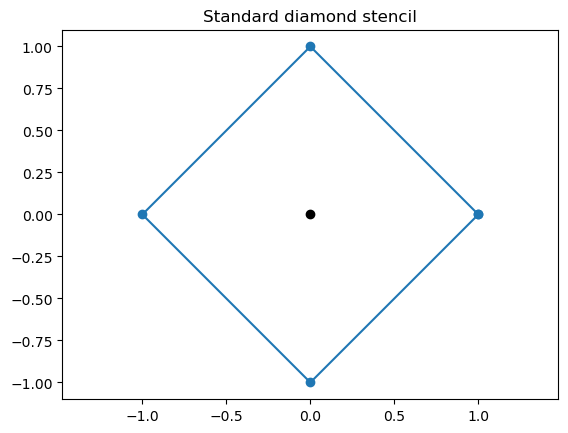

In [5]:
plt.title("Standard diamond stencil"); plt.axis('equal')
PlotStencil(MakeStencil(lambda u,v: False)); 

One can generate an isotropic stencil by setting an upper requiring bound on the angle between consecutive elements. For now we use the standard isotropic Euclidean measure of angle.

In [6]:
iso = Metrics.Isotropic(1)

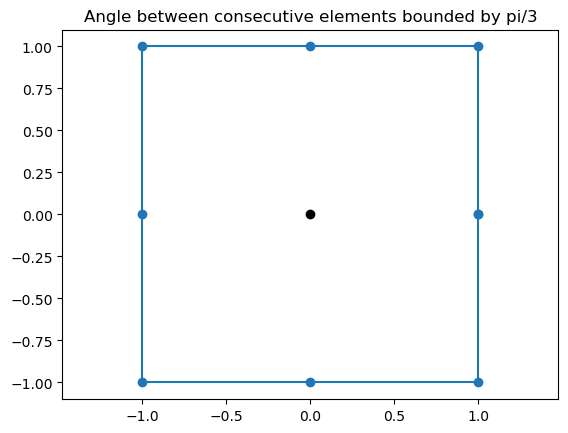

In [7]:
plt.title("Angle between consecutive elements bounded by pi/3"); plt.axis('equal')
PlotStencil(MakeStencil(lambda u,v: iso.angle(u,v)>np.pi/3))

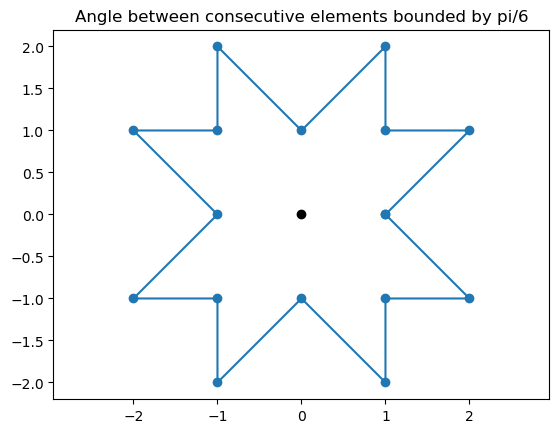

In [8]:
plt.title("Angle between consecutive elements bounded by pi/6"); plt.axis('equal')
PlotStencil(MakeStencil(lambda u,v: iso.angle(u,v)>np.pi/6))

## 2. Angular measure associated with a norm

Some applications require to consider distorted geometries, defined by and anisotropic and possibly asymmetric norm $F$. We can define a corresponding anisotropic measure of (unoriented) angle, as follows:
for any vectors $u,v$
$$
    \angle_F(u,v) := \min\{\angle^*_F(u,v),\angle^*_F(v,u)\},
$$
where 
$$
    \cos\angle^*_F(u,v) := <\nabla F(u),v>/F(v).
$$

**Euclidean an Riemannian special cases.**
If $F(x) = \|x\|$ is the Euclidean norm, then $\angle_F(u,v)$ is the standard (unoriented) Euclidean angle, and $\angle^*_F(u,v)=\angle^*_F(v,u)$.

More generally, if $F(x) = \|x\|_M = \sqrt{<x,M x>}$ is the norm associated with a symmetric positive definite matrix $M$, then $\angle_F(u,v)$ is angle associated with the Riemannian scalar product, defined by 
$$
    \cos\angle_F(u,v) = \frac{<u,Mv>}{\|u\|_M \|v\|_M},
$$
and again $\angle^*_F(u,v)=\angle^*_F(v,u)$.

**General case**
One can show that $<\nabla F(u),v> \leq F(v)$ for any non-zero vectors $u,v$, with equality if $u=v$. 
However, the lower bound $<\nabla F(u),v> \geq -F(v)$ can only be guaranteed for symmetric norms, a.k.a. $F(v)=F(-v)$. This makes the concept of obtuse angle w.r.t. an asymmetric norm ill defined in general, but this is not a real issue since our application only involves acute angles.

In general, one also has $\angle^*_F(u,v) \neq \angle^*_F(v,u)$. 



**Interest of the notion in the general case.**
The *acuteness implies causality* principle (Tsitsilikis, Sethian, Kimmel, Vladimirsky, ...), states the following:  a discretization of the eikonal equation based on stencils whose consecutive elements make acute angles, w.r.t. the metric, can be solved in a single pass via the Fast Marching Method, a Dijkstra-like algorithm.

Solving the eikonal equation is a natural approach to compute path-length distances w.r.t. those geometries. Due to their serial nature, such PDE solvers are more efficiently implemented in C++, as in the Hamilton-Fast-Marching library. We only illustrate here the stencil construction.

**Anisotropy ratio.**
The amount of distortion induced by a norm is measured by the anisotropy ratio
$$
    \mu(F) := \max_{\|u\|=\|v\|=1} \frac{F(u)}{F(v)}
$$

In [9]:
aX0 = np.linspace(-1,1); aX1=aX0
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

def ball_and_stencil(metric,level,name):
    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1); plt.title("Unit ball for a norm of "+name+" type"); plt.axis('equal')
    plt.contourf(*X,metric.norm(X),levels=[0.,level]); plt.scatter(0,0,color='black'); 
    plt.subplot(1,2,2); plt.title("Stencil for a norm of "+name+" type"); plt.axis('equal')
    PlotStencil(MakeStencil(lambda u,v: metric.angle(u,v)>np.pi/3))

### 2.1 Riemannian metric

The norms associated with a Riemannian metric take the form
$$
    F(u) = \|u\|_M = \sqrt{<u,M u>},
$$
where $M$ is a given symmetric positive definite matrix.

We illustrate the stencil construction with a needle like Riemannian metric, whose unit ball is strongly elongated in a given direction.

In [10]:
direction = np.array([np.cos(np.pi/6),np.sin(np.pi/6)])
riemann = Metrics.Riemann.needle(direction,cost_parallel=1,cost_orthogonal=5)

A different cost of motion is set parallel to the given direction and in the orthogonal direction. See the unit ball below.

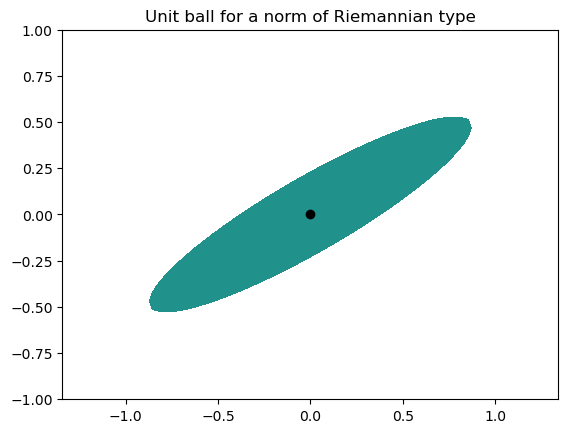

In [11]:
plt.title("Unit ball for a norm of Riemannian type"); plt.axis('equal')
plt.contourf(*X,riemann.norm(X),levels=[0.,1.]); plt.scatter(0,0,color='black'); 

This is an instance of an anisotropic metric.

In [12]:
riemann.anisotropy(), riemann.is_definite()

(5.000000000000007, True)

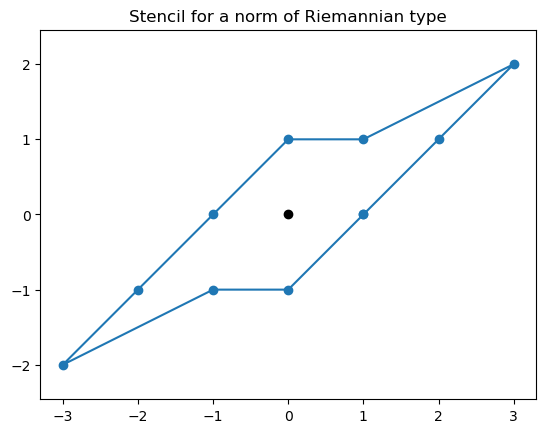

In [13]:
plt.title("Stencil for a norm of Riemannian type"); plt.axis('equal')
PlotStencil(MakeStencil(lambda u,v: riemann.angle(u,v)>np.pi/3))

The dual norm is in general 'plate-like', but the distinction is artificial in dimension two.

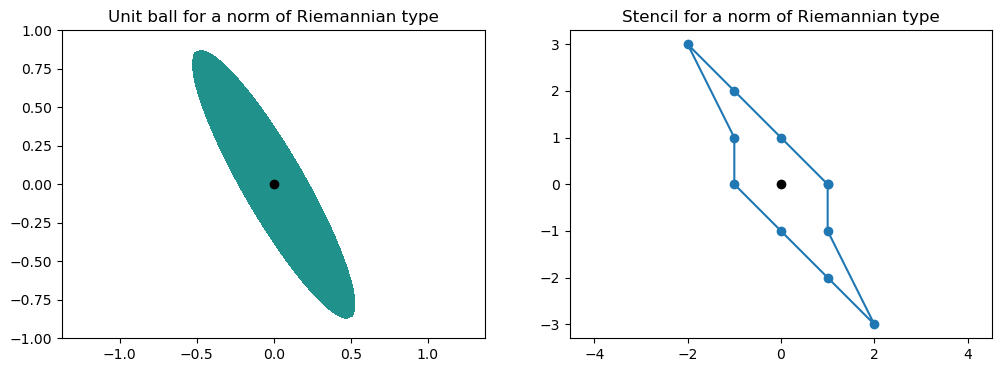

In [14]:
ball_and_stencil(riemann.dual(),0.2,"Riemannian")

### 2.2 Asymmetric quadratic metric

The norms associated with an asymmetric quadratic metric take the form:
$$
    F(u) = \sqrt{<u,M u> + \max\{0,<w,u>\}^2}.
$$
The norm parameters are $M$ is a symmetric positive definite matrix, and $w$ a vector.

We again define a needle-like norm. But it is asymmetric this time, and imposes a strong cost of motion opposite to the given direction.

In [15]:
asym_quad = Metrics.AsymQuad.needle(direction,1,5)

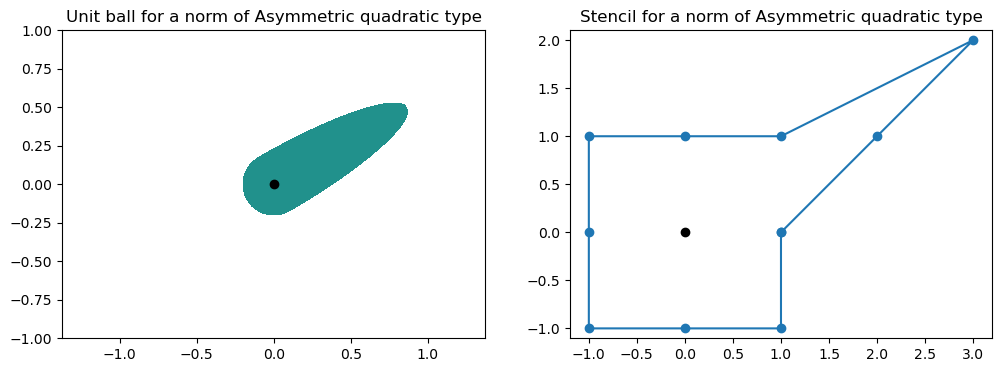

In [16]:
ball_and_stencil(asym_quad,1.,"Asymmetric quadratic")

In [17]:
asym_quad.anisotropy(),asym_quad.is_definite()

(5.000000000000007, True)

The dual norm puts a strong cost on motion in a half space, and a an isotropic cost in the other half space.

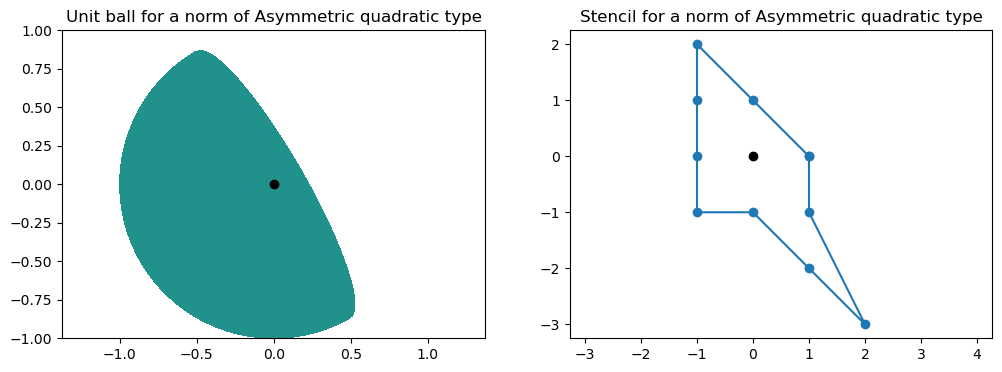

In [18]:
ball_and_stencil(asym_quad.dual(),0.2,"Asymmetric quadratic")

### 2.3 Rander metric

The norms associated with a Rander metric take the form
$$
    F(u) = \|u\|_M + <w,u>,
$$
The norm parameters are $M$ is a symmetric positive definite matrix, and $w$ a vector, which is subject to the compatibility condition
$$
    \|w\|_{M^{-1}} < 1.
$$

Rander metrics occur in Zermelo's navigation problem, modeling e.g. a boat in subject to a drift due to water currents. They are asymmetric, and their unit ball is an ellipsoid shifted from the origin.

In [19]:
rander = Metrics.Rander.from_Zermelo(np.eye(2),0.7*direction)

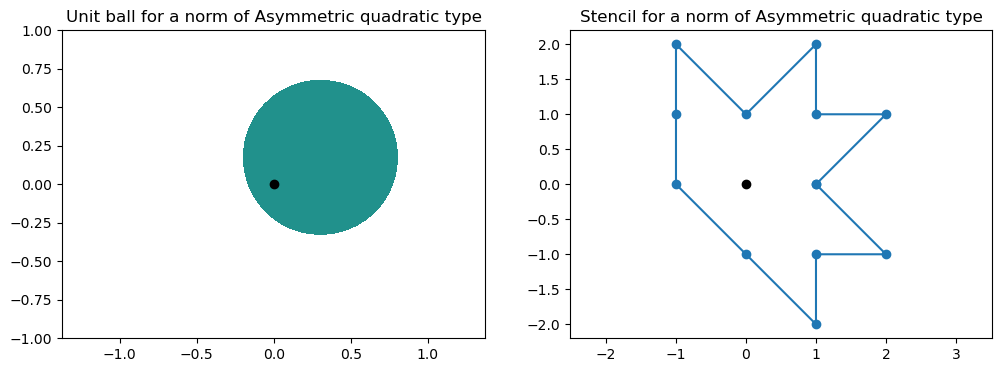

In [20]:
ball_and_stencil(rander,0.5,"Asymmetric quadratic")

The exact anisotropy of a Rander metric is not so easily computed. Instead we provide an anisotropy bound.

In [21]:
rander.anisotropy_bound(), rander.is_definite()

(7.934920476158721, True)

The sharp value is sligtly lower. Here it turns out that the anisotropy bound for the dual metric is sharp.

In [22]:
(1+0.7)/(1-0.7), rander.dual().anisotropy_bound()

(5.666666666666666, 5.666666666666666)

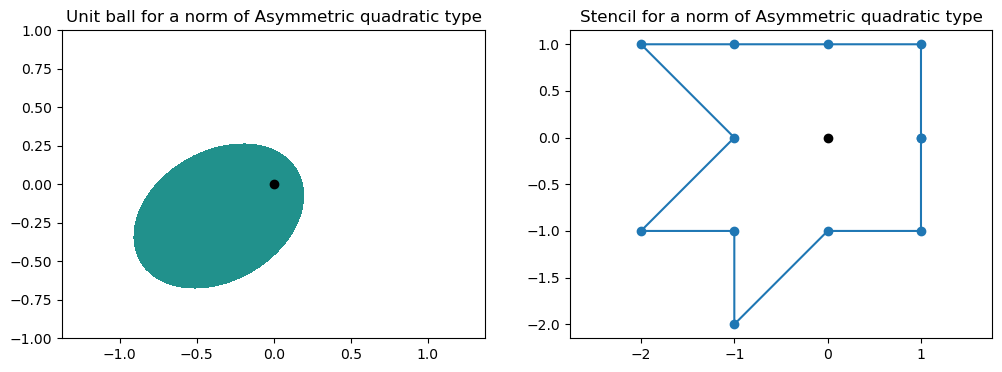

In [23]:
ball_and_stencil(rander.dual(),0.3,"Asymmetric quadratic")